<a href="https://colab.research.google.com/github/alongstar518/cs221_finalproject/blob/master/cs221_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS221 Final Project: Steel Defect Detection 


### install packages

In [1]:
# No for now

### Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image
import shutil

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F
import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zheng/anaconda3/envs/py36/li

### Print torch and cuda information

In [3]:
print("torch version: {}".format(torch.__version__))
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
print("Cuda device name: {}".format(torch.cuda.get_device_name()))
print("Cuda device Capilibility: {}".format(
    torch.cuda.get_device_capability(device=None)
  )
)

torch version: 1.3.0
Cuda device avaliablity: True
Cuda device name: GeForce RTX 2080
Cuda device Capilibility: (7, 5)


### configs


basic config:

In [4]:
reload_data = True
clear_tensor_board_history = False
reload_last_model = False
path = "/content/drive/My Drive/share/"
if not os.path.exists(path):
    path = "/home/zheng/git/cs221_finalproject"
data_path = os.path.join(
    path, "data", "severstal-steel-defect-detection"
) # path to data
model_save_path = os.path.join(path, "best.pth")

train_data_percent = 0.8
eval_data_percent = 0.1
test_data_percent = 0.1 # used only when we don`t have any eval set.

hyperparamters:

In [5]:
batch_size = 16
n_classes = 1
total_epochs = 300
weight_decay=1e-4 
lr = 0.01
momentum=0.9
eval_interval = 200

### download data

In [6]:
try:
  # delay import so we can run on local machine
  # this also check if run it on google drive or not . if it is not, it will 
  # avoiding runing from google colab, but running from local.
  from google.colab import drive 
  data_zip_path = os.path.join(
      data_path, "severstal-steel-defect-detection.zip"
      )
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  path = "/content/data/"
  res18_path = os.path.join(data_path, "resnet18")
  res18_path_dst = os.path.join(path, "resnet18")
  # you may find res18 folder here:
  # "https://drive.google.com/drive/folders/
  #  1KFKRraGbNUICgkgSabzrfHeJzYc5YE0W?usp=sharing"

  if reload_data:
    print("login to google drive")
    drive.mount('/content/drive')
    print("Copy res18 folder: ")
    shutil.copytree(res18_path, res18_path_dst)

    print("Copy raw data from {} to {}".format(
        data_zip_path, data_zip_path_dst)
    )
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(path,"train_images.zip"), 
        os.path.join(path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(path,"test_images.zip"), 
        os.path.join(path,"test_images")
      )
    )
    on_colab = True
    !ls /content/data
except:
  on_colab = False



In [7]:
tr = pd.read_csv(os.path.join(data_path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [8]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId']
.apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


### Masks

In [9]:
# Decod
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

# Encode
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Display some images

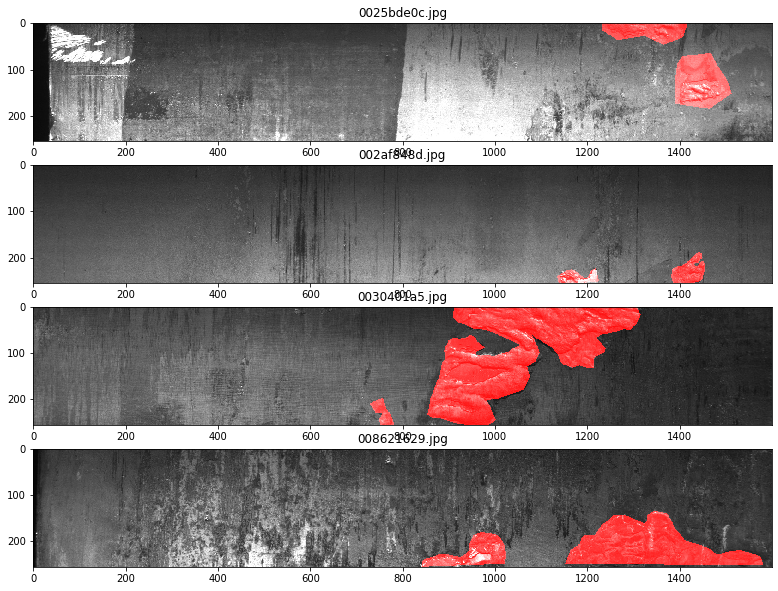

In [10]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( data_path + '/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset argumentation and DataLoader

In [11]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = data_path + '/train_images/'
        elif self.subset == "test":
            self.data_path = data_path + '/test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img  

In [12]:
# Not enable augumentation yet
data_transf = transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.ToTensor()
    ]
)

train_indx = int(len(df_train) * train_data_percent)
df_tr = df_train[0: train_indx]

eval_indx = int(len(df_train) * eval_data_percent) + train_indx
df_eval = df_train[train_indx: eval_indx]

df_test = df_train[eval_indx:]

train_data = ImageData(df = df_tr, transform = data_transf)
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True
  )

eval_data = ImageData(df = df_eval, transform = data_transf)
eval_loader = DataLoader(dataset = eval_data)

test_data = ImageData(df = df_test, transform = data_transf)
test_data = DataLoader(dataset = test_data)

### Show some image and mask

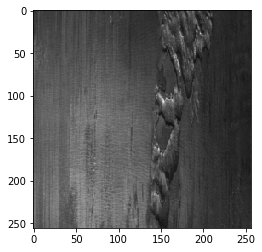

In [13]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

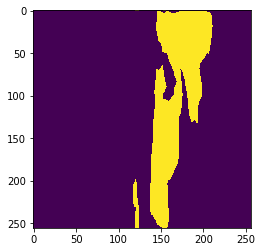

In [14]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

### Models

UNet:

In [15]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load(os.path.join(data_path, "resnet18/resnet18.pth")))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

### Train Preparation

In [16]:
model = UNet(n_class=1).cuda()
if reload_last_model and os.path.exists(model_save_path):
  print("Loading model from {}".format(model_save_path))
  model.load_state_dict(torch.load(model_save_path))
else:
  print("Not load model, train from scrath")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.parameters(), weight_decay=weight_decay, lr = lr, momentum=momentum
)

Not load model, train from scrath


### Define Functions for training eval and test

Get LR value if we use lr decay

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Eval Matrics:

In [18]:
SMOOTH = 1e-6

def dice_coefficient(x, y):
  """
  :param X: numpy array
  :param y: numpy array
  :return: float, dice coefficient for one x, y pair
  x, y is mask the preidiction values (mask)
  """
  x = x.squeeze()
  y = y.squeeze()
  #print(sum(((x*y) > 0)))
  #print(sum((x+y) > 0))
  return 2. * np.sum(((x*y) > 0)) / (np.sum(x > 0) + np.sum(y > 0))

def iou(x, y):
  x = x.reshape(-1, 1)
  y = y.reshape(-1, 1)
  #print(sum(((x*y) > 0)))
  #print(sum((x+y) > 0))
  return np.sum(((x*y) > 0)) / np.sum((x + y) > 0)

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded


Inference:

In [19]:
def predict(model, data_loader, resize=False, out_mask=True):
    predict = []
    Y = []
    raw = []
    model.eval()
    print("Predicting...")
    total = 0
    losses = []
    with tqdm_notebook(total=len(data_loader.dataset), leave=True) as pbar:
      for data, y in data_loader:
        o = model(data.cuda())  
        o = o.cpu().detach().numpy() * (-1)
        tmp = np.copy(o)
        mn = np.mean(o)*1.2
        tmp[tmp<mn] = 0
        tmp[tmp>mn] = 1
        predict.append(tmp)
        loss = criterion(torch.tensor(tmp), y)
        losses.append(loss)
        Y.append(y)
        raw.append(data)
        pbar.update(1)
    predict_loss = np.average(losses)
    print(f"Predict Loss = {predict_loss}")
    return predict, Y, raw, predict_loss


Eval Data:

In [20]:
def eval_data_set(model, data_loader, matrics):
  corr = []
  predictions, Y, raw, loss = predict(model, data_loader)
  for i, mask in enumerate(predictions):
    corr.append(dice_coefficient(mask, Y[i].numpy()))
  return np.mean(corr), predictions, Y, raw, loss

Launch Tensorbaord:

In [21]:
if clear_tensor_board_history:
  shutil.rmtree("/content/runs", ignore_errors=True)
  os.mkdir("/content/runs")

In [22]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 6599), started 1:58:42 ago. (Use '!kill 6599' to kill it.)

### Training

In [ ]:
summary_writter = SummaryWriter() # in ./run by default
total_it = 0
last_result = 0
current_it = 0
for epoch in range(total_epochs):
  print(f"Epoch: {epoch}")
  model.train()
  with tqdm_notebook(total=len(train_loader.dataset)) as pbar:   
    for it, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        data_len = len(data)
        pbar.update(len(data))
        pbar.set_postfix(epoch=epoch, loss=loss.item())
        total_it += data_len
        summary_writter.add_scalar("Loss/train", loss.item(), total_it)
        summary_writter.add_scalar("LR/train", get_lr(optimizer), total_it)
        summary_writter.flush()
    # eval after each epoch
    corr, predictions, Y, raw, loss = eval_data_set(
        model, eval_loader, iou_numpy
        )
    summary_writter.add_scalar("MDC/evaluation", corr, total_it)
    summary_writter.add_scalar("Loss/train", loss.item(), total_it)
    for i, mask in enumerate(predictions):
        summary_writter.add_image('images_img', raw[i].squeeze(), current_it)
        images_to_add = [torch.Tensor(
            mask.reshape(1,mask.shape[2], mask.shape[3])), 
            Y[i].reshape(1,Y[i].shape[2], Y[i].shape[3])
            ]
        grid = torchvision.utils.make_grid(images_to_add)
        summary_writter.add_image('images_mask', grid, current_it)
        current_it += 1
    print("Result = {}".format(corr))
    if corr > last_result:
      print("Saving Model...")
      torch.save(model.state_dict(), model_save_path)
      last_result = corr
    summary_writter.flush()
summary_writter.close()

Epoch: 0


Predicting...



Predict Loss = 0.796069324016571
Result = 0.22663875727625346
Saving Model...

Epoch: 1


Predicting...



Predict Loss = 0.7641456723213196
Result = 0.11756527955591478

Epoch: 2


In [ ]:
### Test on Test Set

In [ ]:
corr, _, _, _, _ = eval_data_set(model, eval_loader, dice_coefficient)
print("Test set Corr = {}".format(corr))

### Show prediction on image from train dataset

In [ ]:
plt.imshow(train_data[3][1].permute(1, 2, 0))

In [ ]:
x = train_data[6][0].unsqueeze(0)
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

In [ ]:
plt.imshow(np.squeeze(train_data[6][1]))